## 1. Setup and data load

In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

TRAIN_PATH = "training.csv"   # Kaggle file with Label + Weight
TEST_PATH  = "test.csv"       # Kaggle file without Label

df = pd.read_csv(TRAIN_PATH)
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [37]:
print(df.shape)
print(df.columns.tolist())
print(df[['Label','Weight']].head())


(250000, 33)
['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'Weight', 'Label']
  Label    Weight
0     s  0.002653
1     b  2.233584
2     b  2.347389
3     b  5.446378
4     b  6.245333


## 2. Prep features

In [38]:
# Convert to 1/0, since XGBoost expects numerical values
# s shows an importance of 90, while b shows an importance of 84
df['y'] = (df['Label'] == 's').astype(int)

# Drop non-feature columns  present in this dataset
drop_cols = ['EventId', 'Label']
if 'Weight' in df.columns:
    drop_cols.append('Weight') 

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['y'].values
w = df['Weight'].values if 'Weight' in df.columns else np.ones(len(df))

# Train/valid split 
X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(
    X, y, w, test_size=0.2, random_state=42, stratify=y
)

# Class imbalance helper (scale pos weight)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)
scale_pos_weight


np.float64(1.9182595500043773)

## 3. Baseline XGBoost

c:\Users\icecr\anaconda3\envs\AAI627\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:50:54] WARNING: D:\bld\xgboost-split_1758007517675\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Baseline ROC-AUC: 1.0000


<Figure size 1000x600 with 0 Axes>

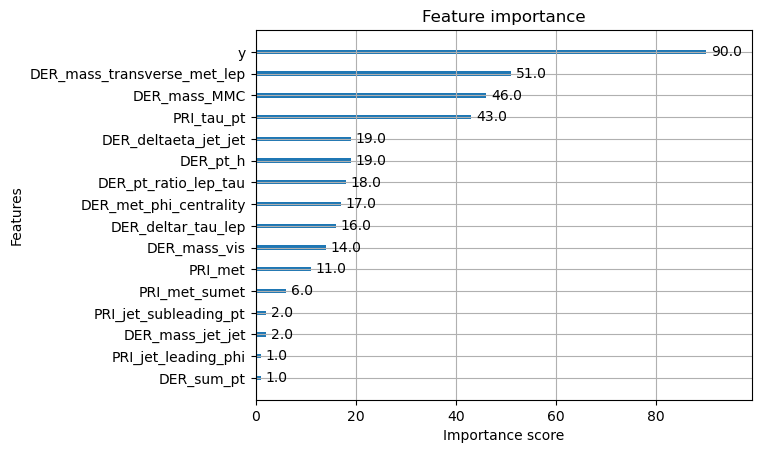

In [39]:
baseline_model = XGBClassifier(
    objective="binary:logistic", 
    #This tells XGBoost to treat the task as binary classification, 
    #predicting the probability that a sample belongs to class 1 (from s)

    eval_metric="auc", # Use AUC as evaluation metric        
    use_label_encoder=False,   
    n_estimators=200,          
    learning_rate=0.1,         
    max_depth=6,               
    subsample=0.8,             
    colsample_bytree=0.8,      
    scale_pos_weight=scale_pos_weight,  
    random_state=42
)

baseline_model.fit(
    X_train, y_train,
    sample_weight=w_train
)

y_valid_pred = baseline_model.predict_proba(X_valid)[:, 1]

auc = roc_auc_score(y_valid, y_valid_pred, sample_weight=w_valid)
print(f"Baseline ROC-AUC: {auc:.4f}")

plt.figure(figsize=(10, 6))
plot_importance(baseline_model, max_num_features=20)
plt.show()


### Raw scores based on how often and how effectively each feature was used in the decision trees. However, these include the label Y, which should not be counted in the dataset

c:\Users\icecr\anaconda3\envs\AAI627\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:50:56] WARNING: D:\bld\xgboost-split_1758007517675\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Baseline ROC-AUC: 1.0000


<Figure size 1000x600 with 0 Axes>

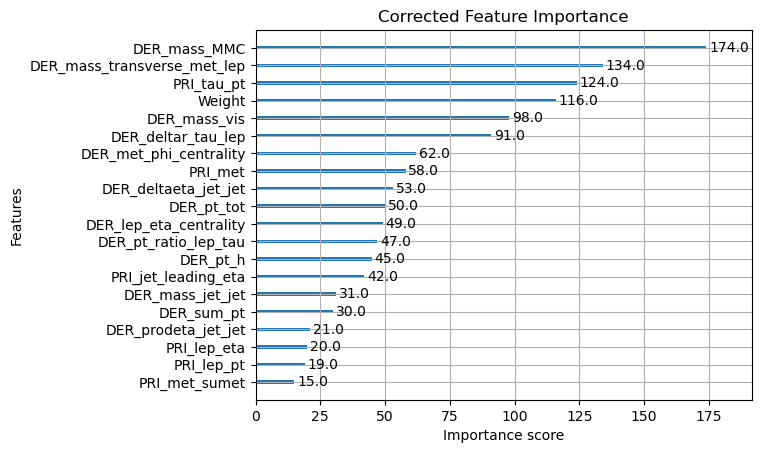

In [40]:
df['y'] = (df['Label'] == 's').astype(int)
X = df.drop(columns=['Label', 'y'])
y = df['y']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Train new baseline model without bindary 
baseline_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

baseline_model.fit(X_train, y_train)

# Evaluate
y_valid_pred = baseline_model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_valid_pred)
print(f"Baseline ROC-AUC: {auc:.4f}")

# Plot corrected feature importance
plt.figure(figsize=(10, 6))
plot_importance(baseline_model, max_num_features=20)
plt.title("Corrected Feature Importance")

plt.show()


## 4. Tuning. WIll user RandomizedSearcCV then Scikit-optimize's BayesSearchCV for hyperparameter tuning
- ranodmized is good for quick results, easy parallelizarion, exploring generally
- optimize for most performance, fine tune a baseline search

In [43]:
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Search space (focused but covers the usual suspects)
param_dist = {
    "learning_rate": loguniform(1e-3, 3e-1),   # ~[0.001, 0.3]
    "max_depth": randint(3, 11),               # [3..10]
    "min_child_weight": loguniform(1e-1, 1e1), # ~[0.1, 10]
    "gamma": loguniform(1e-3, 5),              # ~[0.001, 5]
    "subsample": uniform(0.5, 0.5),            # [0.5..1.0]
    "colsample_bytree": uniform(0.5, 0.5),     # [0.5..1.0]
    "reg_lambda": loguniform(1e-1, 1e1),       # ~[0.1, 10]
    "reg_alpha": loguniform(1e-3, 1e1),        # ~[0.001, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We’ll run a reasonably sized random search; tune n_iter up/down for time vs depth
rs = RandomizedSearchCV(
    estimator=baseline_model,
    param_distributions=param_dist,
    n_iter=60,                  # try 60 random combos
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    refit=False,                # we'll refit the best params with early stopping
    random_state=42
)

# IMPORTANT: pass sample weights into .fit (works in sklearn>=0.24)
rs.fit(X_train, y_train, **({"sample_weight": w_train} if "w_train" in globals() else {}))

print("Best CV AUC (RandomizedSearchCV):", rs.best_score_)
print("Best params:", rs.best_params_)

# Refit the best model on train with early stopping using the validation fold
best_params = rs.best_params_
best_model_rs = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_estimators=2000,           # large cap; early stopping cuts it down
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    **best_params
)

best_model_rs.fit(
    X_train, y_train,
    sample_weight=(w_train if "w_train" in globals() else None),
    eval_set=[(X_valid, y_valid)],
    eval_sample_weight=[(w_valid if "w_valid" in globals() else None)],
    verbose=False,
    early_stopping_rounds=75
)

# Evaluate
y_valid_pred = best_model_rs.predict_proba(X_valid)[:, 1]
auc_rs = roc_auc_score(y_valid, y_valid_pred)
print(f"RandomizedSearchCV → Valid ROC-AUC: {auc_rs:.5f}")
print("Best iteration:", best_model_rs.best_iteration)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV AUC (RandomizedSearchCV): 1.0
Best params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(3.2859708169642414), 'learning_rate': np.float64(0.06504856968981275), 'max_depth': 7, 'min_child_weight': np.float64(1.5620693675639872), 'reg_alpha': np.float64(0.06071989493441298), 'reg_lambda': np.float64(0.15847101210439093), 'subsample': np.float64(0.7296244459829335)}


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_sample_weight'

In [ ]:
# Refit the best model on train with early stopping using the validation fold
best_params = rs.best_params_
best_model_rs = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_estimators=2000,           # large cap; early stopping cuts it down
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    **best_params
)

best_model_rs.fit(
    X_train, y_train,
    sample_weight=(w_train if "w_train" in globals() else None),
    eval_set=[(X_valid, y_valid)],
    eval_sample_weight=[(w_valid if "w_valid" in globals() else None)],
    verbose=False,
    early_stopping_rounds=75
)

# Evaluate
y_valid_pred = best_model_rs.predict_proba(X_valid)[:, 1]
auc_rs = roc_auc_score(y_valid, y_valid_pred)
print(f"RandomizedSearchCV → Valid ROC-AUC: {auc_rs:.5f}")
print("Best iteration:", best_model_rs.best_iteration)
